## Define plot parameters and imports

In [1]:
import matplotlib.font_manager as fm
import matplotlib.ft2font as ft
import matplotlib

import matplotlib.font_manager as fm
import matplotlib.ft2font as ft
import matplotlib

from matplotlib import rc
import seaborn as sns


sns.set_style('ticks')
sns.set_context('paper', font_scale=2.25)
fig_dict = {
    'figsize':[8.0, 6.0],
}
math_dict = {
    'fontset': 'cm',
}
legend_dict = {
    'fontsize': 20,
    'markerscale': 2.7,
}
savefig_dict = {
    'bbox': 'tight',
    'transparent': 'True',
    'pad_inches': 0.1,
}
axes_dict = {
    'titlesize': '20',
    'titlepad': '5.5',
    'labelsize': '25',
    'labelpad': '7',
    'formatter.use_mathtext' : 'True'
}
lines_dict = {
    'linewidth': 2.7,
}

rc('figure', **fig_dict)
rc('mathtext', **math_dict)
rc('legend', **legend_dict)
rc('savefig', **savefig_dict)
rc('axes', **axes_dict)
rc('lines', **lines_dict)

from matplotlib.font_manager import FontProperties

f_name = '/Users/ruth/Helvetica/helvetica_regular.ttf'
fm.fontManager.addfont(f_name)
font = ft.FT2Font(f_name)

custom_font = FontProperties(fname= f_name)

matplotlib.rcParams['font.sans-serif'].insert(0, font.family_name)
matplotlib.rcParams['font.family'] = font.family_name

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from numpy.linalg import norm

from sgd_methods import one_pass_sgd, one_pass_sign_sgd, vanilla_ode, sign_ode, one_pass_clipped_sgd, clipped_ode
from reduction_factors import mu_GAU, nu_GAU, mu_STU, nu_STU, nu_GMM, mu_GMM

## Load the wikitext2 dataset

Dataset processes and created in gen_wikitext2 script.

In [3]:
data = np.load('embeddings.npy')
targets = np.load('targets.npy')


n = data.shape[0]
ambient_d = data.shape[1]


target_mean = targets.mean() 
target_max = np.max(targets)
targets = (targets - target_mean) / target_mean

In [4]:
# Estimate the covariance
ambient_d = 1000
rf_mat = np.random.randn(data.shape[1], ambient_d)
# data = np.maximum(data @ rf_mat, 0)
data = np.tanh(data @ rf_mat)

data = data - np.mean(data, axis=0) # Should be mean 0 already, doesn't hurt
K = data.T @ data / n

op_norm = norm(K, ord = 2)
print(f'Original op. norm: {op_norm}')
data = data / np.sqrt(op_norm)
K = K / op_norm
op_norm = 1.

# ambient_d = K.shape[0]
print(op_norm)
print(f'Rescaled op. norm: {op_norm}')

# ambient_d = K.shape[0]
d = np.trace(K) / op_norm
print(f'Intrinsic dimension: {d}')

Original op. norm: 15.374345681495097
1.0
Rescaled op. norm: 1.0
Intrinsic dimension: 3.332577288672821


In [5]:
## First we need to find a good optimal
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

model = LinearRegression(fit_intercept=False)
model.fit(data, targets)

y_pred = model.predict(data)
mse = mean_squared_error(y_pred, targets)
print(f'Sklearn gives MSE: {mse}')


Sklearn gives MSE: 0.45903230670455014


In [6]:
x_star = model.coef_

# For signSGD x0 and x_star should be pretty close together
x0 = x_star + np.random.randn(ambient_d) * 0.6

# Also need the std of the error
err = targets - y_pred
noise_std = np.std(err)
print(f'Estimated error std: {np.sqrt(noise_std)}')
print(f'Distance to optimal : {norm(x0 -x_star)}')
# print(f'Acc: {np.sum(np.sign(y_pred) == targets) / n}')

Estimated error std: 0.8231154809583668
Distance to optimal : 19.238380477959335


In [7]:
from scipy import stats
import scipy
from sklearn.mixture import GaussianMixture
tpdf = stats.t.pdf


err = err.reshape(-1, 1)  # Reshape to a 2D array for GMM input

n_components = 3
gmm = GaussianMixture(n_components=n_components, random_state=0)
gmm.fit(err)

# Get the parameters of the fitted GMM
weights = gmm.weights_
means = gmm.means_
covariances = gmm.covariances_

print("Weights:", weights)
print("Means:", means)
print("Covariances:", covariances)

Weights: [0.39262565 0.2629399  0.34443445]
Means: [[-0.6895938 ]
 [ 0.94690543]
 [ 0.06445447]]
Covariances: [[[0.03392982]]

 [[0.03005429]]

 [[0.04038324]]]


In [8]:
# Fit the residuals to the Student's t-distribution
params = stats.t.fit(err)

# Extract the parameters
df, loc, scale = params

print(f"Degrees of Freedom (df): {df}")
print(f"Location (mean): {loc}")
print(f"Scale (std dev): {scale}")

num_runs = 50

Degrees of Freedom (df): 93702899409.61746
Location (mean): 0.0004273346631929535
Scale (std dev): 0.6775191460909389


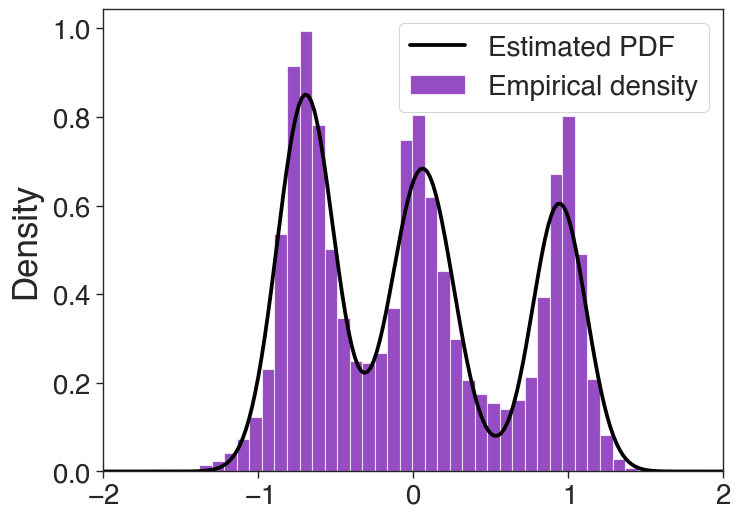

In [9]:
#Initialize lists to store the results
T = n / d
d = np.trace(K)
lr = 0.4
c = 0.5

m = 2
x = np.linspace(-m,m,200)
x = x.reshape(-1, 1)

logprob = gmm.score_samples(x)
pdf = np.exp(logprob)
cmap = 'plasma'
hist_col = plt.get_cmap(cmap)(0.2)
plt.hist(err, density=True, bins= 80, alpha = 0.7, color = hist_col)
plt.xlim([-m,m])

# Plot the GMM
plt.plot(x, pdf, color = 'black')
plt.ylabel('Density')
plt.legend(['Estimated PDF', 'Empirical density'])

name = f'wikitext2_num_runs_{num_runs}_random_feat_intdim{d:.3f}_lr_{lr}_GMM_noise_next_token_pred.pdf'
plt.savefig('noise_hist' + name, format = 'pdf')
plt.show()

In [10]:
lrk = lr / d
ck = c * np.sqrt(d)

num_runs = 50

sgd_risk_list = []
sgd_time_list = []
clipped_sgd_risk_list = []
clipped_sgd_time_list = []

for _ in range(num_runs):
    # Shuffle data and targets together
    shuffled_indices = np.random.permutation(len(data))
    data_shuffled = data[shuffled_indices]
    targets_shuffled = targets[shuffled_indices]
    
    # Run one pass of SGD and clipped SGD
    sgd_risk, sgd_time = one_pass_sgd(K, data_shuffled, targets_shuffled, x0, x_star, lrk)
    clipped_sgd_risk, clipped_sgd_time = one_pass_clipped_sgd(K, data_shuffled, targets_shuffled, x0, x_star, lrk, ck)
    
    # Save results
    sgd_risk_list.append(sgd_risk)
    sgd_time_list.append(sgd_time)
    clipped_sgd_risk_list.append(clipped_sgd_risk)
    clipped_sgd_time_list.append(clipped_sgd_time)

# Convert results to arrays (optional)
sgd_risk_array = np.array(sgd_risk_list)
sgd_time_array = np.array(sgd_time_list)
clipped_sgd_risk_array = np.array(clipped_sgd_risk_list)
clipped_sgd_time_array = np.array(clipped_sgd_time_list)

In [11]:
# Set confidence level
confidence = 0.8
q_low = (1 - confidence) / 2
q_high = 1/2 + confidence/2

# Compute quantiles for confidence interval
sgd_low = np.quantile(sgd_risk_array, q_low, axis=0)
sgd_high = np.quantile(sgd_risk_array, q_high, axis=0)

clipped_sgd_low = np.quantile(clipped_sgd_risk_array, q_low, axis=0)
clipped_sgd_high = np.quantile(clipped_sgd_risk_array, q_high, axis=0)

# Compute the ODEs
mu_nu_args = {'weights': weights, 'means': means, 'covariances': covariances, 'c': c} # GMM args
clipped_ode_risk, ode_time,_,_ = clipped_ode(K,T, x0, x_star, lr, mu_GMM, nu_GMM, mu_nu_args)

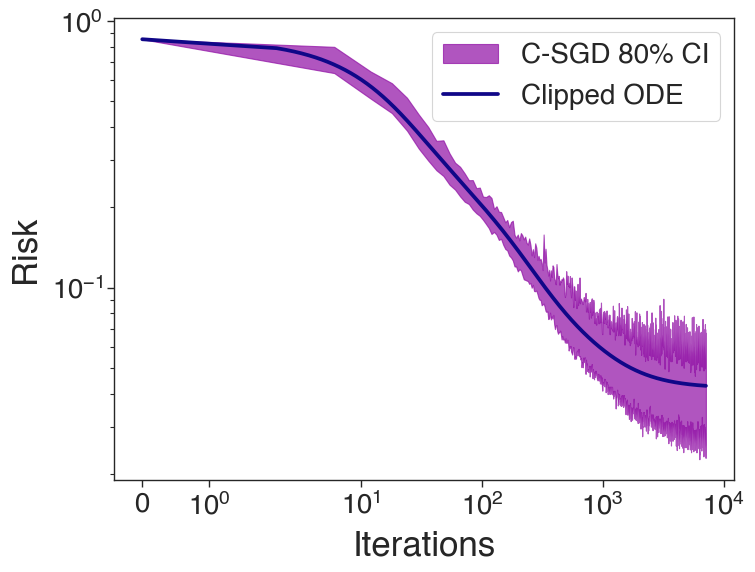

In [12]:
# Set the colormap and colors
cmap = 'plasma'
unc_sgd_color = plt.get_cmap(cmap)(0.66)
clipped_sgd_color = plt.get_cmap(cmap)(0.3)
ode_color = plt.get_cmap(cmap)(1)

plt.fill_between(clipped_sgd_time / d, clipped_sgd_low, clipped_sgd_high, color=clipped_sgd_color, alpha=0.7, label='C-SGD 80% CI')

# Plot ODE results
plt.plot(ode_time, clipped_ode_risk, color=ode_color, label='Clipped ODE')

plt.xscale('symlog')
plt.yscale('log')
plt.xlabel('Iterations')
plt.ylabel('Risk')
plt.legend()
plt.savefig(f'wikitext2_num_runs_{num_runs}_random_feat_intdim{d:.3f}_lr_{lr}_GMM_noise.pdf', format = 'pdf')
# plt.grid(True)
plt.show()